TODO:
    - Pretty up relevant plots
    - Add/improve textual descriptions/markdown
    - Triangulate returner position, linear reg prediction, nn prediction. Use stdev of actual ball landing positions to draw heat map from center point

In [153]:
%matplotlib notebook

In [154]:
from types import SimpleNamespace

import matplotlib.animation as anm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split


pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

COLUMN = SimpleNamespace(**{
    'PLAY_TYPE': 'specialTeamsPlayType',
    'SPECIAL_TEAMS_RESULT': 'specialTeamsResult',
    'POSITION': 'position',
    'PLAY_EVENT': 'event',
    'GAME_ID': 'gameId',
    'PLAY_ID': 'playId',
    'HOME_TEAM': 'homeTeamAbbr',
    'VISITOR_TEAM': 'visitorTeamAbbr',
    'TEAM': 'team',
    'POSSESSION_TEAM': 'possessionTeam',
    'TIME': 'time',
    'NFL_ID': 'nflId',
    'RETURNER_ID': 'returnerId',
    'PRIMARY_RETURNER_ID': 'primaryReturnerId',
    'X': 'x',
    'Y': 'y',
    'X_X': 'x_x',
    'Y_X': 'y_x',
    'X_Y': 'x_y',
    'Y_Y': 'y_y',
    'COLOR': 'color',
    'FRAME': 'frame',
    'SORT_POSITION': 'sortPosition',
    'PLAYER_TEAM_ABBR': 'playerTeamAbbr',
    'IS_PUNT_TEAM': 'isPuntTeam',
    'PUNT_TEAM_Y_POSITION': 'puntTeamYPosition',
    'REMAINING_SORT_LOCATION': 'remainingSortLocation',
    'SORT_VALUE': 'sortValue',
    'FEATURES': 'features',
    'LINEAR_REG_PREDICTION': 'linearRegressionPrediction',
    'NEURAL_NET_PREDICTION': 'neuralNetworkPrediction',
    'LINEAR_REG_ABS_ERR': 'linearRegressionAbsoluteError',
    'NEURAL_NET_ABS_ERR': 'neuralNetworkAbsoluteError',
})

POSITION = SimpleNamespace(**{
    'PUNTER': 'P',
})

PLAY_TYPE = SimpleNamespace(**{
    'PUNT': 'Punt',
})

PLAY_EVENT = SimpleNamespace(**{
    'BALL_SNAP': 'ball_snap',
    'PUNT': 'punt',
    'PUNT_RECEIVED': 'punt_received',
    'OUT_OF_BOUNDS': 'out_of_bounds',
    'PUNT_LAND': 'punt_land',
    'FAIR_CATCH': 'fair_catch',
    'PUNT_MUFFED': 'punt_muffed',
})

SPECIAL_TEAMS_RESULT = SimpleNamespace(**{
    'BLOCKED': 'Blocked Kick Attempt',
    'DOWNED': 'Downed',
    'RETURN': 'Return',
    'TOUCHBACK': 'Touchback',
    'FAIR_CATCH': 'Fair Catch',
    'MUFFED': 'Muffed',
    'OUT_OF_BOUNDS': 'Out of Bounds',
})

TEAM = SimpleNamespace(**{
    'HOME': 'home',
    'AWAY': 'away',
    'FOOTBALL': 'football',
})

In [155]:
# Load into dataframes
games_df = pd.read_csv('input/games.csv')
plays_df = pd.read_csv('input/plays.csv')
pff_scouting_df = pd.read_csv('input/PFFScoutingData.csv')
tracking_2018_df = pd.read_csv('input/tracking2018.csv')
tracking_2019_df = pd.read_csv('input/tracking2019.csv')
tracking_2020_df = pd.read_csv('input/tracking2020.csv')

In [156]:
# Remove unused columns
columns = list(COLUMN.__dict__.values())
games_df = games_df[games_df.columns.intersection(columns)]
plays_df = plays_df[plays_df.columns.intersection(columns)]
pff_scouting_df = pff_scouting_df[pff_scouting_df.columns.intersection(columns)]
tracking_2018_df = tracking_2018_df[tracking_2018_df.columns.intersection(columns)]
tracking_2019_df = tracking_2019_df[tracking_2019_df.columns.intersection(columns)]
tracking_2020_df = tracking_2020_df[tracking_2020_df.columns.intersection(columns)]

In [157]:
# Initial consolidating and tidying
game_plays_df = pd.merge(games_df, plays_df, left_on=COLUMN.GAME_ID, right_on=COLUMN.GAME_ID)
tracking_df = pd.concat([tracking_2018_df, tracking_2019_df, tracking_2020_df], ignore_index=True)
tracking_df[COLUMN.TIME] = pd.to_datetime(tracking_df[COLUMN.TIME])
tracking_df[COLUMN.NFL_ID] = tracking_df[COLUMN.NFL_ID].astype('Int64')

In [158]:
# Add a column indicating the primary/first returner for each play.
# This will be used as a feature in the models later on.
def getPrimaryReturnerId(value):
    if pd.isnull(value):
        return np.NaN
    returners = str(value).split(';')
    return int(returners[0])

game_plays_df[COLUMN.PRIMARY_RETURNER_ID] = game_plays_df[COLUMN.RETURNER_ID] \
    .apply(getPrimaryReturnerId) \
    .astype('Int64')

In [159]:
# Filter down to punts only
punt_tracking_df = pd.merge(
    pff_scouting_df,
    tracking_df,
    left_on=[COLUMN.GAME_ID, COLUMN.PLAY_ID],
    right_on=[COLUMN.GAME_ID, COLUMN.PLAY_ID],
)
punt_plays_df = game_plays_df[game_plays_df[COLUMN.PLAY_TYPE] == PLAY_TYPE.PUNT]
punt_tracking_df = pd.merge(
    punt_tracking_df,
    punt_plays_df,
    left_on=[COLUMN.GAME_ID, COLUMN.PLAY_ID],
    right_on=[COLUMN.GAME_ID, COLUMN.PLAY_ID],
)

<IPython.core.display.Javascript object>


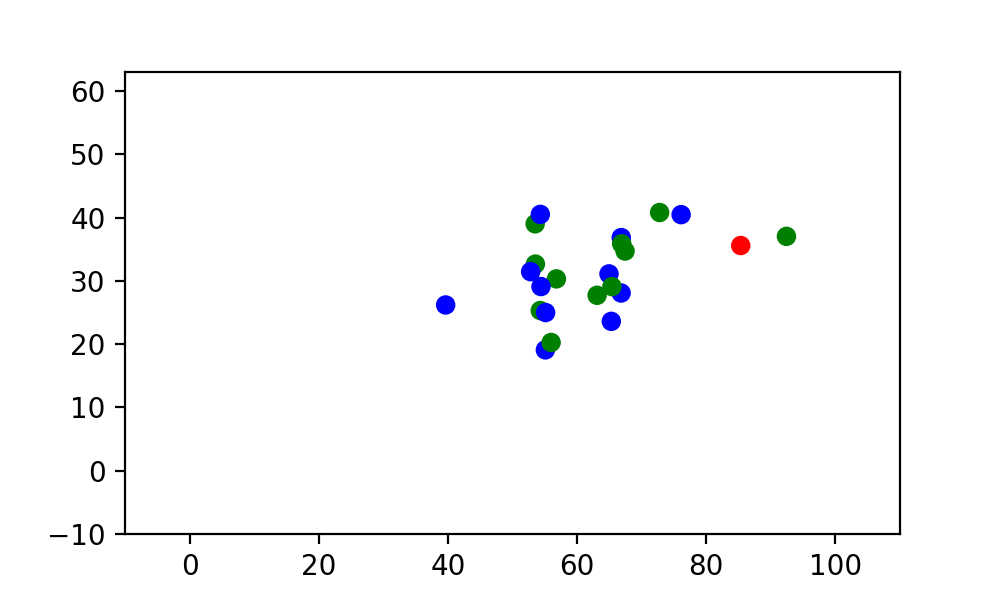

In [160]:
# Plot player and ball positions over the course of each punt for a handful of games

plot_punts_df = punt_tracking_df[punt_tracking_df[COLUMN.GAME_ID] < 2018100000].copy()

plot_punts_df.loc[:, COLUMN.FRAME] = plot_punts_df[[COLUMN.GAME_ID, COLUMN.TIME]] \
    .apply(tuple, axis=1) \
    .rank(ascending=True, method='dense')

conditions = [
    plot_punts_df[COLUMN.TEAM] == TEAM.HOME,
    plot_punts_df[COLUMN.TEAM] == TEAM.AWAY,
    plot_punts_df[COLUMN.TEAM] == TEAM.FOOTBALL,
]
values = [
    'green',
    'blue',
    'red',
]
plot_punts_df.loc[:, COLUMN.COLOR] = np.select(conditions, values)

fig, ax = plt.subplots(figsize=(5, 3))
ax.set(xlim=(-10, 110), ylim=(-10, 63))
first_frame = plot_punts_df[plot_punts_df[COLUMN.FRAME] == 1]
c = first_frame[COLUMN.COLOR]
x = first_frame[COLUMN.X]
y = first_frame[COLUMN.Y]
scatter = ax.scatter(x, y, c=c)

def animate(i):
    filtered = plot_punts_df[plot_punts_df[COLUMN.FRAME] == i+1]
    c = filtered[COLUMN.COLOR]
    x = filtered[COLUMN.X]
    y = filtered[COLUMN.Y]
    data = np.c_[x, y]
    scatter.set_offsets(data)
    scatter.set_color(c)

animation = anm.FuncAnimation(
    fig,
    animate,
    interval=10,
    frames=int(plot_punts_df[COLUMN.FRAME].max()),
    repeat=True,
)
plt.show()

In [161]:
'''
Predict punt landing position based on pre-snap inputs (e.g. ball and player positions)

Inputs:
  - Positions of all players and ball at time of snap (22 players + ball, x and y positions)
Outputs:
  - Ball landing position x, y
  
A, B, C, D, E, F

A * x0 + B * x1 + C * x2 + D * x3 ... = ball landing position

                      SORT
x0 = ball x           1
x1 = ball y           2
x2 = punter x
x3 = punter y
x4 = returner x
x5 = returner y
x6 = player3 x
x7 = player3 y
etc...

y0 = ball landing x
y1 = ball landing y
'''

special_teams_results = [
    SPECIAL_TEAMS_RESULT.RETURN,
    SPECIAL_TEAMS_RESULT.TOUCHBACK,
    SPECIAL_TEAMS_RESULT.FAIR_CATCH,
    SPECIAL_TEAMS_RESULT.DOWNED,
    SPECIAL_TEAMS_RESULT.MUFFED,
    SPECIAL_TEAMS_RESULT.OUT_OF_BOUNDS,
]
ball_land_events = [
    PLAY_EVENT.PUNT_RECEIVED,
    PLAY_EVENT.PUNT_LAND,
    PLAY_EVENT.FAIR_CATCH,
    PLAY_EVENT.PUNT_MUFFED,
]
punt_predict_df = punt_tracking_df[
    punt_tracking_df[COLUMN.SPECIAL_TEAMS_RESULT].isin(special_teams_results)
]

In [162]:
# Label positions of football, punter and returner as features 1, 2 and 3
is_football = punt_predict_df[COLUMN.TEAM] == TEAM.FOOTBALL
is_punter = punt_predict_df[COLUMN.POSITION] == POSITION.PUNTER
is_returner = (~np.isnan(punt_predict_df[COLUMN.PRIMARY_RETURNER_ID])) \
    & (~np.isnan(punt_predict_df[COLUMN.NFL_ID])) \
    & (punt_predict_df[COLUMN.PRIMARY_RETURNER_ID] == punt_predict_df[COLUMN.NFL_ID])
inputs_df = punt_predict_df[punt_predict_df[COLUMN.PLAY_EVENT] == PLAY_EVENT.BALL_SNAP].copy()

conditions = [
    (inputs_df[COLUMN.TEAM] == TEAM.FOOTBALL),
    (inputs_df[COLUMN.POSITION] == POSITION.PUNTER),
    np.where(inputs_df[COLUMN.PRIMARY_RETURNER_ID].fillna(-1) == inputs_df[COLUMN.NFL_ID].fillna(-2), True, False),
]
values = [1, 2, 3]
inputs_df.loc[:, COLUMN.SORT_POSITION] = np.select(conditions, values)

In [163]:
# Use the remaining player positions sorted by team and y position for the rest of our features
inputs_df.loc[:, COLUMN.PLAYER_TEAM_ABBR] = np.where(
    inputs_df[COLUMN.TEAM] == TEAM.HOME,
    inputs_df[COLUMN.HOME_TEAM],
    inputs_df[COLUMN.VISITOR_TEAM],
)
inputs_df.loc[:, COLUMN.IS_PUNT_TEAM] = np.where(
    inputs_df[COLUMN.PLAYER_TEAM_ABBR] == inputs_df[COLUMN.POSSESSION_TEAM],
    True,
    False,
)
inputs_df.loc[:, COLUMN.PUNT_TEAM_Y_POSITION] = inputs_df[[COLUMN.IS_PUNT_TEAM, COLUMN.Y]].apply(tuple, axis=1)
inputs_df.loc[:, COLUMN.REMAINING_SORT_LOCATION] = inputs_df.groupby([COLUMN.GAME_ID, COLUMN.PLAY_ID])[COLUMN.PUNT_TEAM_Y_POSITION] \
    .rank(method='first')
inputs_df.loc[:, COLUMN.REMAINING_SORT_LOCATION] = inputs_df[COLUMN.REMAINING_SORT_LOCATION] + 3
inputs_df.loc[:, COLUMN.SORT_VALUE] = np.where(
    inputs_df[COLUMN.SORT_POSITION] > 0,
    inputs_df[COLUMN.SORT_POSITION],
    inputs_df[COLUMN.REMAINING_SORT_LOCATION],
)

In [164]:
# Assemble sorted tracking data into model input a.k.a features
inputs_df = inputs_df.sort_values(by=[COLUMN.GAME_ID, COLUMN.PLAY_ID, COLUMN.SORT_VALUE])

aggs = { COLUMN.X: lambda x: x.to_list(), COLUMN.Y: lambda y: y.to_list() }
inputs_df = inputs_df.groupby([COLUMN.GAME_ID, COLUMN.PLAY_ID]).agg(aggs).reset_index()

# Remove plays where we have missing tracking data for the ball and/or one or more players
inputs_df = inputs_df[
    (inputs_df[COLUMN.X].map(len) == 23)
    & (inputs_df[COLUMN.Y].map(len) == 23)
]

# Remove plays where returner is near line of scrimmage as this is not indicative of a typical punt play
inputs_df = inputs_df[
    np.abs(inputs_df[COLUMN.X].str[0] - inputs_df[COLUMN.X].str[2]) > 10
]

# Combine coordinates into x and y pairs
def merge_coordinates(df):
    merged = []
    for i in range(23):
        merged.append(df[COLUMN.X][i])
        merged.append(df[COLUMN.Y][i])
    return merged

inputs_df[COLUMN.FEATURES] = inputs_df.apply(merge_coordinates, axis=1)

In [165]:
# Filter to ball landing position for model output
outputs_df = punt_predict_df[
    (punt_predict_df[COLUMN.PLAY_EVENT].isin(ball_land_events))
    & (punt_predict_df[COLUMN.TEAM] == TEAM.FOOTBALL)
].sort_values(by=[COLUMN.GAME_ID, COLUMN.PLAY_ID]).copy()

In [166]:
# Merge model inputs/outputs and use 80/20 train test split
model_data_df = pd.merge(
    inputs_df,
    outputs_df,
    left_on=[COLUMN.GAME_ID, COLUMN.PLAY_ID],
    right_on=[COLUMN.GAME_ID, COLUMN.PLAY_ID],
)

X = np.array(model_data_df[COLUMN.FEATURES].tolist())
y = model_data_df[[COLUMN.X_Y, COLUMN.Y_Y]].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

In [167]:
# Fit our linear regression model
reg = LinearRegression().fit(X_train, y_train)

In [168]:
# Calculate linear regression model predictions
model_data_df[COLUMN.LINEAR_REG_PREDICTION] = reg.predict(X).tolist()

<IPython.core.display.Javascript object>


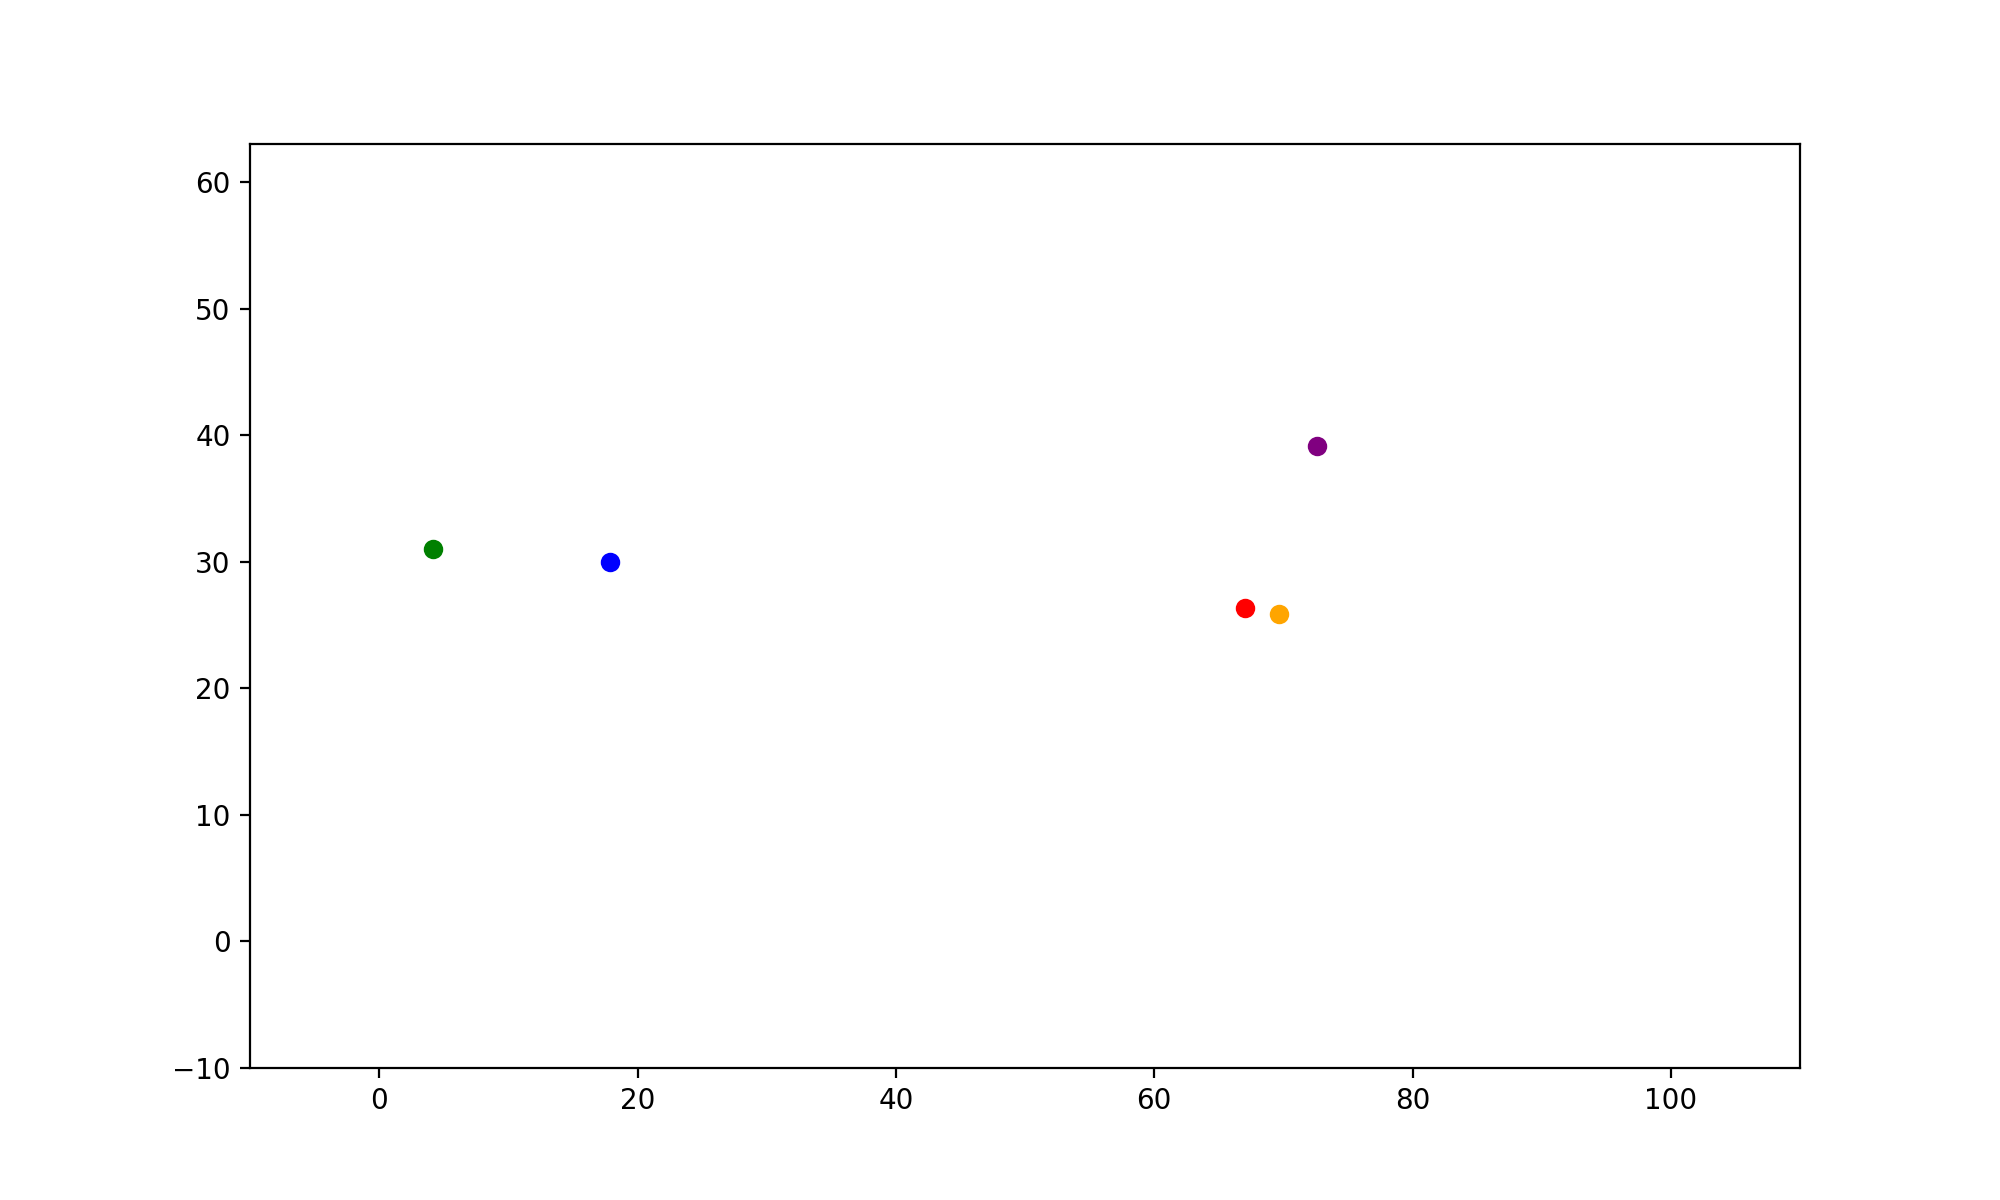

In [169]:
# Plot linear regression model predictions for each play
row = 0
fig, ax = plt.subplots(figsize=(10, 6))
ax.set(xlim=(-10, 110), ylim=(-10, 63))
c = 'blue'
football_x = model_data_df.iloc[row][COLUMN.X_X][0]
football_y = model_data_df.iloc[row][COLUMN.Y_X][0]
ax.scatter(x=football_x, y=football_y, c=c)
c = 'green'
punter_x = model_data_df.iloc[row][COLUMN.X_X][1]
punter_y = model_data_df.iloc[row][COLUMN.Y_X][1]
ax.scatter(x=punter_x, y=punter_y, c=c)
c = 'red'
returner_x = model_data_df.iloc[row][COLUMN.X_X][2]
returner_y = model_data_df.iloc[row][COLUMN.Y_X][2]
ax.scatter(x=returner_x, y=returner_y, c=c)
c = 'purple'
actual_x = model_data_df.iloc[row][COLUMN.X_Y]
actual_y = model_data_df.iloc[row][COLUMN.Y_Y]
ax.scatter(x=actual_x, y=actual_y, c=c)
c = 'orange'
predict_x = model_data_df.iloc[row][COLUMN.LINEAR_REG_PREDICTION][0]
predict_y = model_data_df.iloc[row][COLUMN.LINEAR_REG_PREDICTION][1]
ax.scatter(x=predict_x, y=predict_y, c=c)
plt.show()

In [170]:
# Predict X
model_data_df[COLUMN.LINEAR_REG_PREDICTION].str[0].describe()

count    4243.000000
mean       60.288747
std        28.638319
min        14.386186
25%        32.469396
50%        68.392742
75%        87.103201
max       105.175940
Name: linearRegressionPrediction, dtype: float64

In [171]:
# Actual X
model_data_df[COLUMN.X_Y].describe()

count    4243.000000
mean       60.320714
std        29.303900
min        11.650000
25%        30.865000
50%        64.610000
75%        88.340000
max       109.640000
Name: x_y, dtype: float64

In [172]:
# Predict Y
model_data_df[COLUMN.LINEAR_REG_PREDICTION].str[1].describe()

count    4243.000000
mean       26.389451
std         6.869954
min        -2.852511
25%        21.316455
50%        26.493080
75%        31.465904
max        68.400452
Name: linearRegressionPrediction, dtype: float64

In [173]:
# Standard deviation of predicted y position is much smaller than actual
# Actual Y
model_data_df[COLUMN.Y_Y].describe()

count    4243.000000
mean       26.496821
std        13.345194
min        -8.400000
25%        15.390000
50%        26.430000
75%        37.820000
max        55.650000
Name: y_y, dtype: float64

In [174]:
# Define the neural network regression model
def get_model(n_inputs, n_outputs):
    model = Sequential()
    model.add(Dense(23 * 2 * 10, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(n_outputs))
    model.compile(loss='mae', optimizer='adam')
    return model

model = get_model(X.shape[1], y.shape[1])

In [175]:
# Train the neural network regression model
model.fit(X_train, y_train, verbose=0, epochs=1000)

In [176]:
# Calculate neural network model predictions
model_data_df[COLUMN.NEURAL_NET_PREDICTION] = model.predict(X).tolist()

<IPython.core.display.Javascript object>


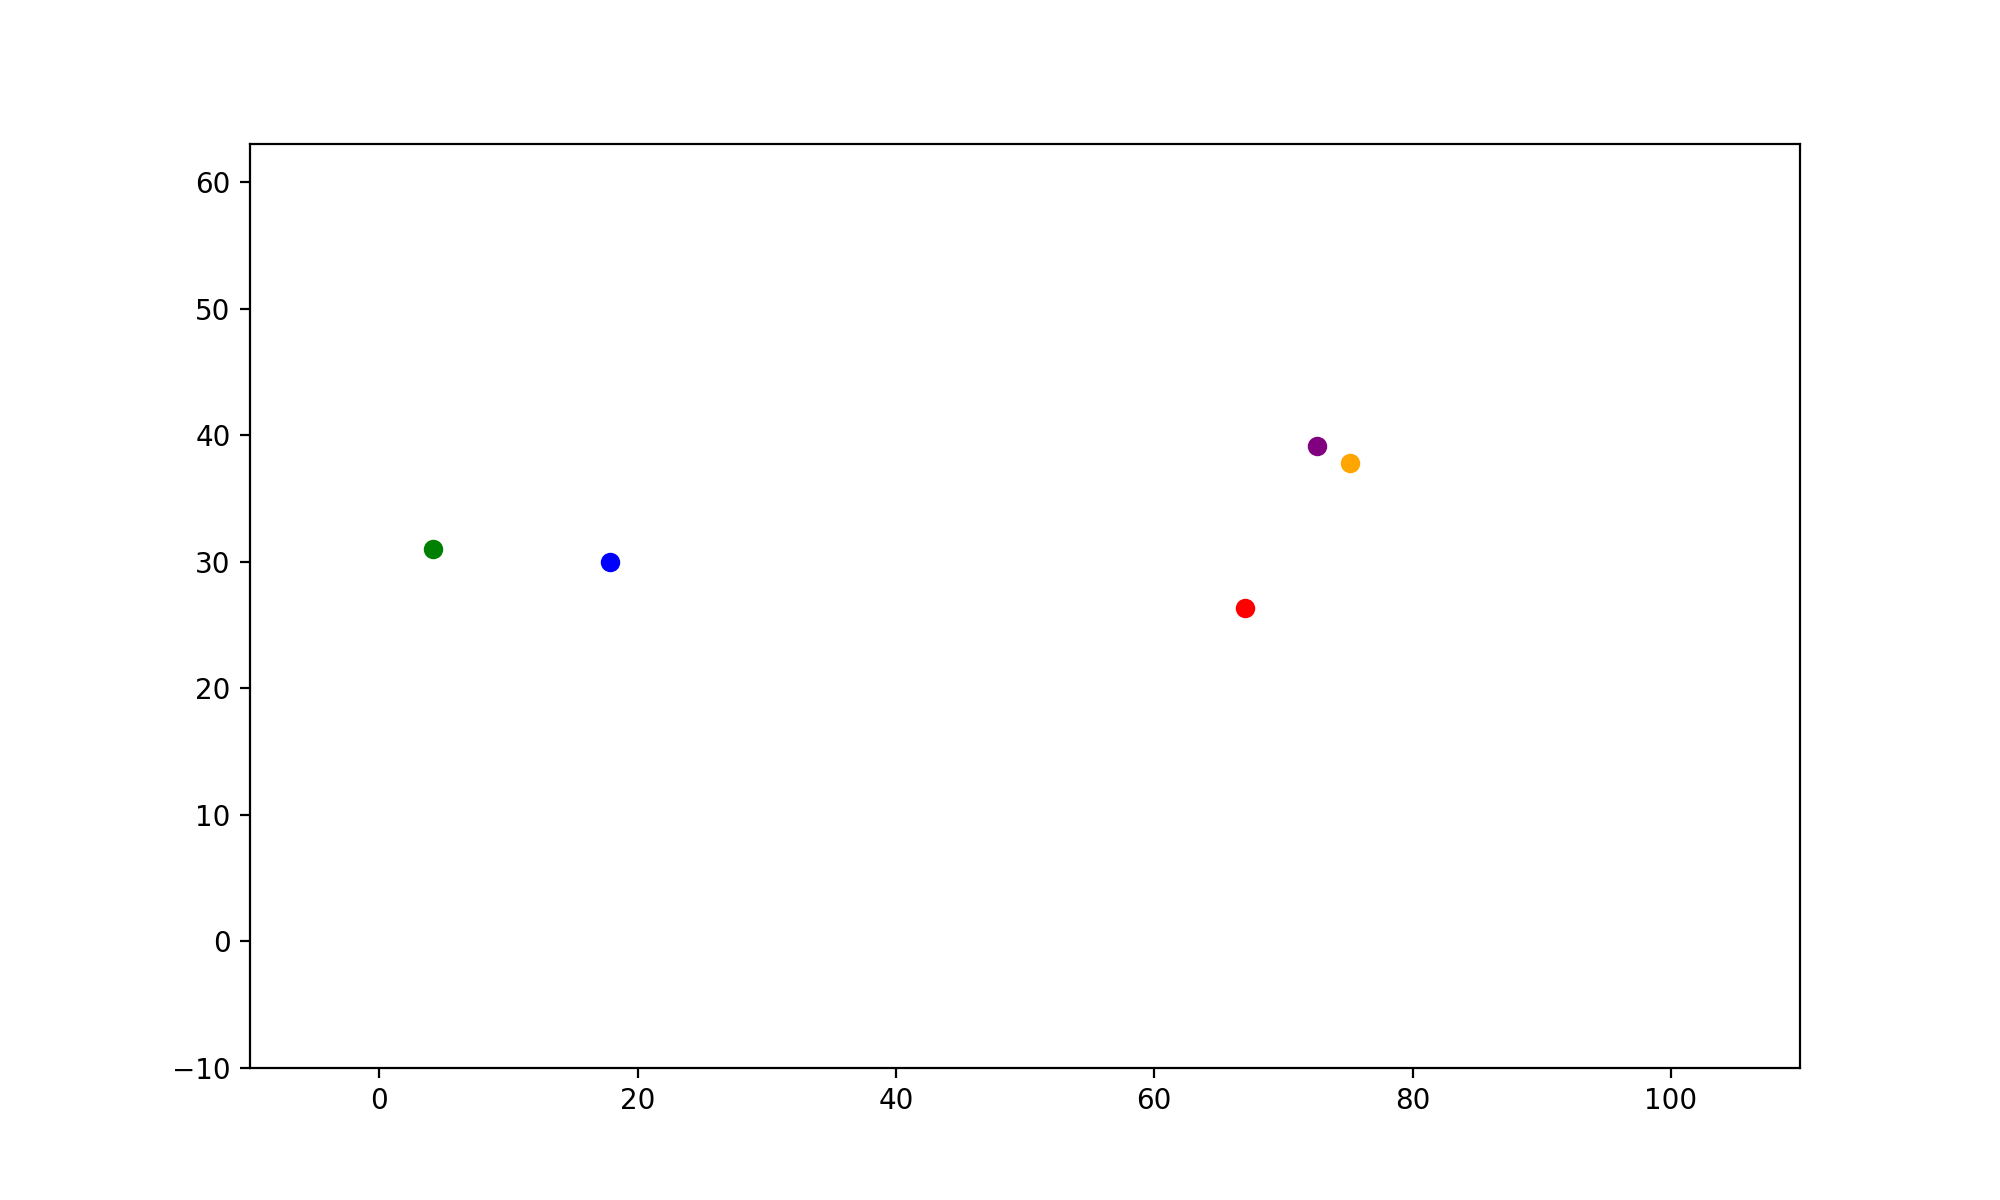

In [177]:
# Plot neural network regression model predictions for each play
row = 0
fig, ax = plt.subplots(figsize=(10, 6))
ax.set(xlim=(-10, 110), ylim=(-10, 63))
c = 'blue'
football_x = model_data_df.iloc[row][COLUMN.X_X][0]
football_y = model_data_df.iloc[row][COLUMN.Y_X][0]
ax.scatter(x=football_x, y=football_y, c=c)
c = 'green'
punter_x = model_data_df.iloc[row][COLUMN.X_X][1]
punter_y = model_data_df.iloc[row][COLUMN.Y_X][1]
ax.scatter(x=punter_x, y=punter_y, c=c)
c = 'red'
returner_x = model_data_df.iloc[row][COLUMN.X_X][2]
returner_y = model_data_df.iloc[row][COLUMN.Y_X][2]
ax.scatter(x=returner_x, y=returner_y, c=c)
c = 'purple'
actual_x = model_data_df.iloc[row][COLUMN.X_Y]
actual_y = model_data_df.iloc[row][COLUMN.Y_Y]
ax.scatter(x=actual_x, y=actual_y, c=c)
c = 'orange'
predict_x = model_data_df.iloc[row][COLUMN.NEURAL_NET_PREDICTION][0]
predict_y = model_data_df.iloc[row][COLUMN.NEURAL_NET_PREDICTION][1]
ax.scatter(x=predict_x, y=predict_y, c=c)
plt.show()

In [178]:
# Calculate mean absolute error for both models against all data
model_data_df[COLUMN.LINEAR_REG_ABS_ERR] = (
    (model_data_df[COLUMN.X_Y] - model_data_df[COLUMN.LINEAR_REG_PREDICTION].str[0]) ** 2 +
    (model_data_df[COLUMN.Y_Y] - model_data_df[COLUMN.LINEAR_REG_PREDICTION].str[1]) ** 2
) ** 0.5
model_data_df[COLUMN.NEURAL_NET_ABS_ERR] = (
    (model_data_df[COLUMN.X_Y] - model_data_df[COLUMN.NEURAL_NET_PREDICTION].str[0]) ** 2 +
    (model_data_df[COLUMN.Y_Y] - model_data_df[COLUMN.NEURAL_NET_PREDICTION].str[1]) ** 2
) ** 0.5

In [179]:
# Calculate mean absolute error for both models against test data
y_test_predict = reg.predict(X_test)
linearRegressionAbsoluteErrorTest = (
    (y_test[:, 0] - y_test_predict[:, 0]) ** 2 +
    (y_test[:, 1] - y_test_predict[:, 1]) ** 2
) ** 0.5
y_nn_test_predict = model.predict(X_test)
neuralNetworkAbsoluteErrorTest = (
    (y_test[:, 0] - y_nn_test_predict[:, 0]) ** 2 +
    (y_test[:, 1] - y_nn_test_predict[:, 1]) ** 2
) ** 0.5

In [180]:
model_data_df[COLUMN.LINEAR_REG_ABS_ERR].mean()

11.48498065557291

In [181]:
np.mean(linearRegressionAbsoluteErrorTest, axis=0)

11.856100053528

In [182]:
model_data_df[COLUMN.NEURAL_NET_ABS_ERR].mean()

11.418735605630127

In [183]:
np.mean(neuralNetworkAbsoluteErrorTest, axis=0)

11.857647563429893

In [184]:
# Score the linear regression model on train data
reg.score(X_train, y_train)

0.6110465786806514

In [185]:
# Score the linear regression model on test data
reg.score(X_test, y_test)

0.5947613428940737

In [186]:
# Evaluate the neural network regression model on train data
model.evaluate(X_train, y_train)

107/107 [==============================] - 0s 837us/step - loss: 6.9556


6.955601215362549

In [187]:
# Evaluate the neural network regression model on test data
model.evaluate(X_test, y_test)

27/27 [==============================] - 0s 915us/step - loss: 7.3648


7.364779472351074